# Producing GITM Plots for Gannon Storm Event

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
#from apexpy import Apex
import os
import datetime as dt
import importlib as il
import glob

#from p_tqdm import p_map
from multiprocessing import Pool
import itertools



In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

utils = '/Users/prasoonv/repo/sat-interp-tid-analysis/'

import sys
sys
sys.path.append(f'{utils}prasoon_utility_programs')
sys.path.append(f'{utils}Qingyu_Cesar_EIA_IHA')
sys.path.append(f'{work}')
sys.path.append(f'{utils}Models/new/GITM/srcPython')

import gitm
import functions
import functions_gitm
import plot_3D_global
from mpl_toolkits.basemap import Basemap


solar_rout.py unavailable: can't load add_solar_terminator, add_subsolar_point
PySolar not installed, cannot load find_sunside_twilight_sza


<xarray.Dataset> Size: 1MB
Dimensions:         (lon: 90, lat: 180)
Coordinates:
    alt             float64 8B 1.533e+05
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 720B 2.0 6.0 10.0 14.0 ... 350.0 354.0 358.0
Data variables:
    Altitude        (lon, lat) float64 130kB 1.533e+05 1.533e+05 ... 1.533e+05
    Latitude        (lon, lat) float64 130kB -89.5 -88.5 -87.5 ... 88.5 89.5
    Longitude       (lon, lat) float64 130kB 2.0 2.0 2.0 ... 358.0 358.0 358.0
    Rho             (lon, lat) float64 130kB 1.356e-09 1.352e-09 ... 1.508e-09
    Temperature     (lon, lat) float64 130kB 686.5 689.2 691.5 ... 782.2 782.9
    V!Dn!N (up)     (lon, lat) float64 130kB -0.7065 -0.5062 ... 0.1909 0.6438
    V!Dn!N (north)  (lon, lat) float64 130kB -27.58 -33.19 ... -248.4 -244.7
    V!Dn!N (east)   (lon, lat) float64 130kB -7.07 -25.24 ... -15.07 -3.218
    LT              (lon, lat) float64 130kB 2.55 2.55 2.55 ... 2.283 2.283
At

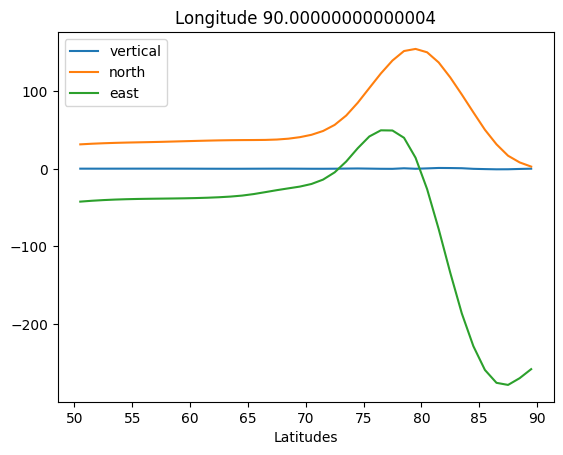

lon_grid shape: (40, 90)
lat_grid shape: (40, 90)


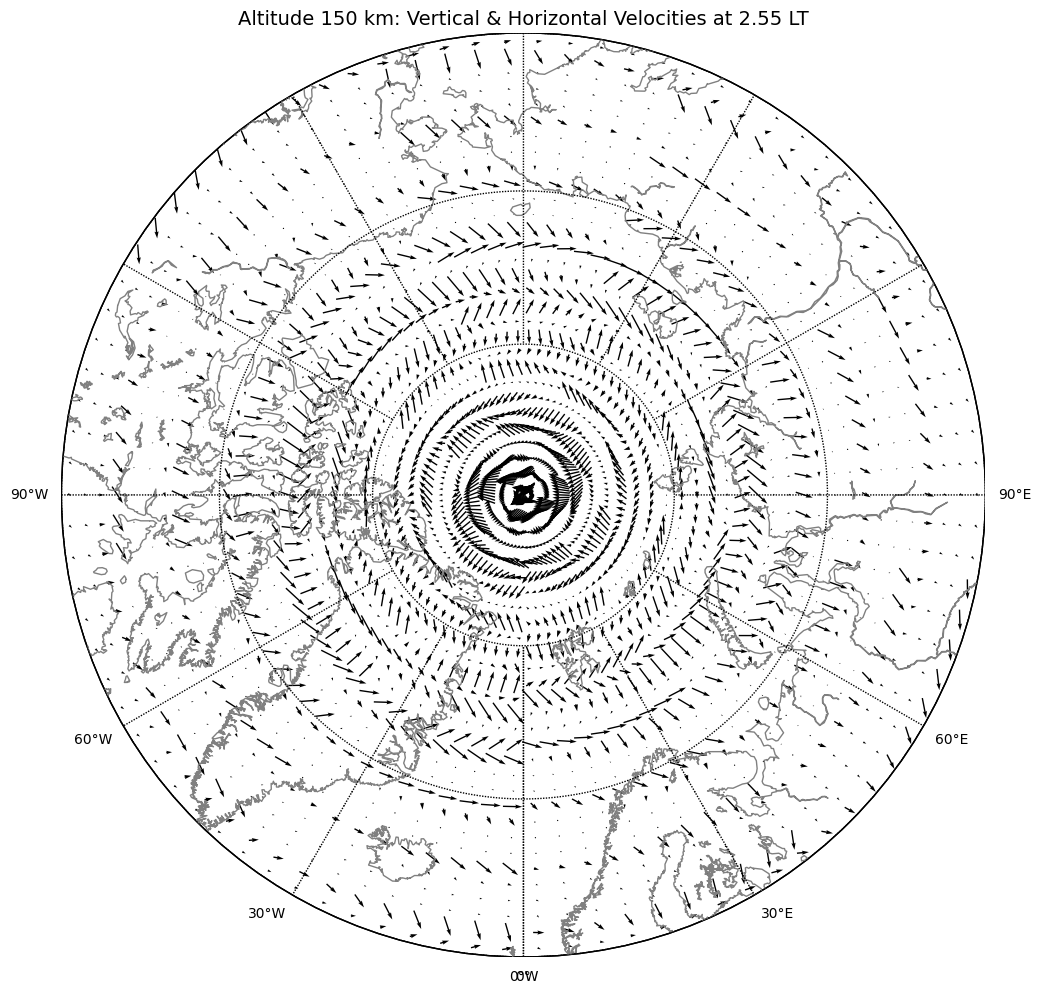

<xarray.Dataset> Size: 195kB
Dimensions:         (lon: 90, lat: 30)
Coordinates:
    alt             float64 8B 1.533e+05
  * lat             (lat) float64 240B 60.5 61.5 62.5 63.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 720B 2.0 6.0 10.0 14.0 ... 350.0 354.0 358.0
Data variables:
    Altitude        (lon, lat) float64 22kB 1.533e+05 1.533e+05 ... 1.533e+05
    Latitude        (lon, lat) float64 22kB 60.5 61.5 62.5 ... 87.5 88.5 89.5
    Longitude       (lon, lat) float64 22kB 2.0 2.0 2.0 ... 358.0 358.0 358.0
    Rho             (lon, lat) float64 22kB 1.629e-09 1.623e-09 ... 1.508e-09
    Temperature     (lon, lat) float64 22kB 742.0 742.6 744.1 ... 782.2 782.9
    V!Dn!N (up)     (lon, lat) float64 22kB -0.4055 -0.5109 ... 0.1909 0.6438
    V!Dn!N (north)  (lon, lat) float64 22kB -55.57 -56.24 ... -248.4 -244.7
    V!Dn!N (east)   (lon, lat) float64 22kB -64.35 -48.66 ... -15.07 -3.218
    LT              (lon, lat) float64 22kB 2.55 2.55 2.55 ... 2.283 2.283 2.283
Attr

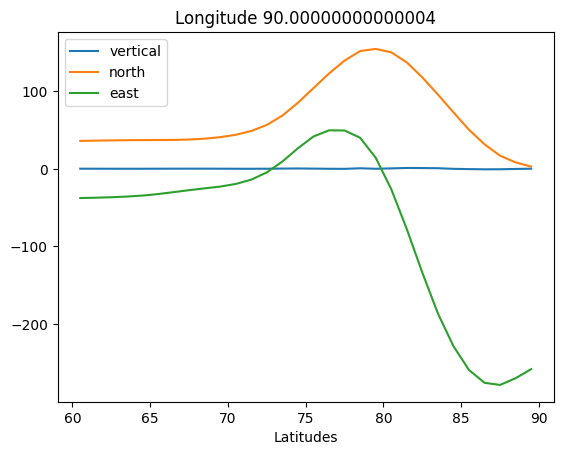

lon_grid shape: (30, 90)
lat_grid shape: (30, 90)


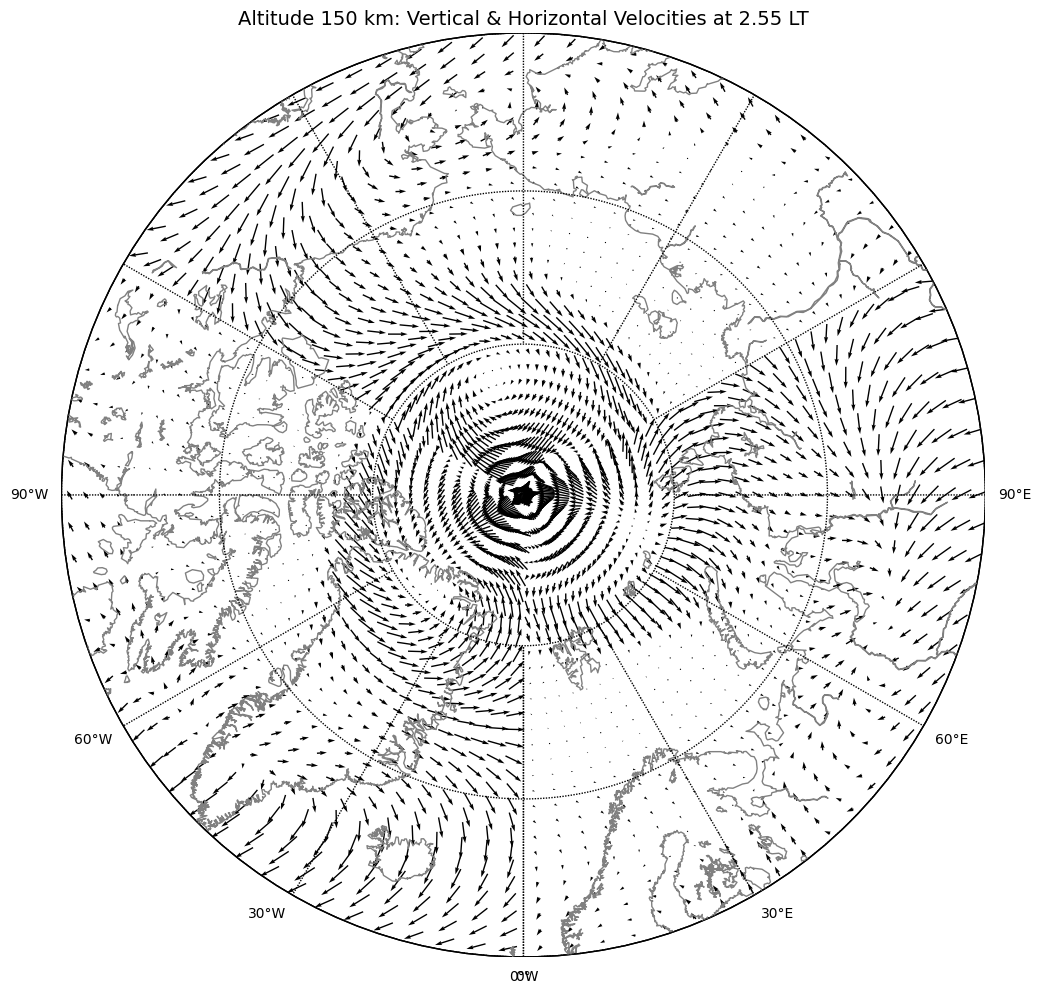

In [103]:
functions_gitm = il.reload(functions_gitm)
plot_3D_global = il.reload(plot_3D_global)
 
# Set working directory and find files
path = f'{work}20240510/UA/data/'
os.chdir(path)
files = glob.glob('3DALL*.bin')
 
# Process each file
for f in files:
    s = gitm.GitmBin(f)
    ds = functions_gitm.gitm_to_xarray(s)
    # Print dataset structure
    #print(ds)
 
    # Select relevant columns
    alt = [1.5e+5, 3e+5, 4.5e+5]
    col = ['Altitude', 'Latitude', 'Longitude', 'Rho', 'Temperature', 'V!Dn!N (up)', 'V!Dn!N (north)', 'V!Dn!N (east)', 'LT']
    ds = ds[col]
 
    # Loop through altitudes
    for a in alt:
        # Try selecting the correct dimension for altitude
        # Change 'alt' to the actual name of the altitude dimension if it's different
        ds_a = ds.sel(alt=a, method='nearest')  # Adjust 'alt' if needed

        # Convert latitudes and longitudes from radians to degrees
        ds_a['Latitude'] = ds_a['Latitude'] * (180 / np.pi)
        ds_a['Longitude'] = ds_a['Longitude'] * (180 / np.pi)
        ds_a.coords['lat'] = ds_a.coords['lat'] * (180 / np.pi)
        ds_a.coords['lon'] = ds_a.coords['lon'] * (180 / np.pi)
        ds_a = ds_a.where((ds_a['lat'] > -90) & (ds_a['lat'] < 90), drop=True)
        ds_a = ds_a.where((ds_a['lon'] > 0) & (ds_a['lon'] <= 360), drop=True)
 
        print(ds_a)
 
        '''
        # Plot longitude vs latitude
        plt.figure(figsize=(12,8))
        plt.scatter(ds_a_n.Longitude.values, ds_a_n.Latitude.values)
        plt.xlabel('Longitudes')
        plt.ylabel('Latitudes')
        plt.show()

        # Plot 3D polar plot of neutral vertical velocity
        f, ax, m = plot_3D_global.plot_single_3D_image('polar', ds_a.Latitude.values, 
                                                       ds_a.Longitude.values, ds_a['V!Dn!N (up)'].values, 'Neutral Vertical velocity', 'linear', 
                                                       'm/s', zmax=None, zmin=None, zcolor=None, title=f'Altitude {int(a / 1000)} km', 
                                                       figname=None, draw=True, nlat=90, slat=0, linc=6, tlon=90, data_type="scatter", 
                                                       bcolor="#D7DBE0", meq=True, earth=False, m=None, faspect=True, term_datetime=False, 
                                                       extra_line=False)
 
        '''
 
 
        latlim = [50, 60]

        for ll in latlim:
            
            # Assuming `ds_a` is your dataset with latitude, longitude, and velocity components
            # Subset data for latitudes 90 to 50 degrees        
            ds_subset = ds_a.where((ds_a['lat'] >= ll) & (ds_a['lat'] <= 90), drop=True)
            print(ds_subset)
            # Extract variables
            lon = ds_subset['lon'].values
            lat = ds_subset['lat'].values
            vertical_v = ds_subset['V!Dn!N (up)'].values  # Vertical velocity (color map)
            north_v = ds_subset['V!Dn!N (north)'].values  # Meridional velocity (quiver)
            east_v = ds_subset['V!Dn!N (east)'].values    # Zonal velocity (quiver)
            print(vertical_v.shape)
            print(north_v.shape)
            print(east_v.shape)

            
            plt.figure()
            plt.plot(lat, vertical_v[22][:], label='vertical')
            plt.plot(lat, north_v[22][:], label='north')
            plt.plot(lat, east_v[22][:], label='east')
            plt.xlabel('Latitudes')
            plt.legend()
            plt.title(f'Longitude {lon[22]}')
            plt.show()
            
            
            
            # Set up the polar stereographic Basemap instance
            fig, ax = plt.subplots(figsize=(12, 12))
            m = Basemap(
                projection='npstere', 
                boundinglat=60, 
                lon_0=0,
                round='True',
                resolution='l', 
                ax=ax)
            # Create lat/lon meshgrid
            lon_grid, lat_grid = np.meshgrid(lon, lat)
            print("lon_grid shape:", lon_grid.shape)
            print("lat_grid shape:", lat_grid.shape)
            # Convert lat/lon to map coordinates
            x, y = m(lon_grid, lat_grid)
            # Add quiver plot for horizontal velocities
            quiver_scale = 12000  # Adjust scale based on the velocity magnitudes
            quiver = m.quiver(
                x, y, north_v, east_v, 
                scale=quiver_scale, 
                color='k', 
                pivot='middle', 
                width=0.0015)
            # Add map features
            m.drawcoastlines(color='gray')
            m.drawparallels(np.arange(ll, 91, 10), labels=[1, 0, 0, 0], fontsize=10)
            m.drawmeridians(np.arange(0, 361, 30), labels=[0, 0, 0, 1], fontsize=10)
            m.drawmapboundary(fill_color='white')
     
            '''
            # Plot the vertical velocity as a color map
            c = m.pcolormesh(x, y, vertical_v, shading='auto', cmap='coolwarm')
            # Add a colorbar
            cb = m.colorbar(c, location='right', pad='5%')
            cb.set_label('Neutral Vertical Velocity (m/s)')
            '''
            # Add title
            plt.title(f'Altitude {int(a / 1000)} km: Vertical & Horizontal Velocities at {ds_subset.LT[0][0].values} LT', fontsize=14)
            # Show plot
            plt.show()
     
 
        
        break  # Remove this if you want to process all files
 
    break  # Remove this if you want to process all altitudes

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Assume these are your wind components and coordinates
latitudes = np.linspace(50, 90, 41)  # From 50° to 90° latitude
longitudes = np.linspace(0, 360, 361)  # Full range of longitudes
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)  # Create a grid

# Meridional, zonal, and vertical winds (replace with actual data)
V_north = np.random.uniform(-50, 50, lon_grid.shape)  # Meridional wind
V_east = np.random.uniform(-50, 50, lon_grid.shape)   # Zonal wind
V_up = np.random.uniform(-10, 10, lon_grid.shape)     # Vertical wind

# Convert lat/lon to radians for polar plotting
lat_radians = np.radians(90 - lat_grid)  # Colatitude
lon_radians = np.radians(lon_grid)

# Create Basemap polar stereographic projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
m = Basemap(projection='npstere', boundinglat=50, lon_0=0, resolution='l', ax=ax)

# Draw parallels and meridians
m.drawparallels(np.arange(50, 91, 10), labels=[True, True, False, False])
m.drawmeridians(np.arange(0, 360, 30), labels=[True, True, True, True])

# Project lat/lon coordinates
x, y = m(lon_grid, lat_grid)

# Plot quiver for horizontal winds (zonal and meridional)
quiver = m.quiver(x, y, V_east, V_north, V_up, cmap='coolwarm', scale=1000)

# Add a colorbar for vertical winds
cbar = m.colorbar(quiver, location='bottom', pad="5%")
cbar.set_label("Vertical Winds (m/s)")

# Title and show the plot
plt.title("Polar Plot: Winds from 90° to 50° Latitude", fontsize=14)
plt.show()


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [7]:
# os.chdir("/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/20240510/UA/")
# files = os.listdir("/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/20240510/UA/data/")
# gitm.GitmBin()

In [4]:
os.chdir("/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/20240510/UA/data/")
files = glob.glob("3DALL*.bin")

In [5]:
# gitmil = il.reload(gitm)

sample = gitm.GitmBin(files[0])

In [6]:
sample


GITM binary output file 3DALL_t240509_022500.bin

In [8]:
def gitm_to_xarray(gitm_bin):
    # Extract attributes from the GITM binary file
    attrs = gitm_bin.attrs
    nLon = attrs['nLon']  # Number of longitude grid points
    nLat = attrs['nLat']  # Number of latitude grid points
    nAlt = attrs['nAlt']  # Number of altitude grid points
    nVars = attrs['nVars']  # Number of variables

    # Extract data and reshape it
    data_vars = {}
    for key in list(gitm_bin.keys())[1:]:  # Skip the first key if it's not a data variable
        data = np.array(gitm_bin[key])  # Convert data to a NumPy array
        data = data.reshape((nLon, nLat, nAlt))  # Reshape data to match the grid dimensions
        data_vars[key] = (['lon', 'lat', 'alt'], data)  # Store data with corresponding coordinates

    # Define coordinates for the xarray.Dataset
    coords = {
        'lon': gitm_bin['Longitude'][:, 0, 0],  # Longitude values
        'lat': gitm_bin['Latitude'][0, :, 0],  # Latitude values
        'alt': gitm_bin['Altitude'][0, 0, :],  # Altitude values
    }

    # Create an xarray.Dataset with the data variables and coordinates
    ds = xr.Dataset(data_vars, coords=coords, attrs=attrs)
    return ds

In [9]:
gitm_data = gitm_to_xarray(sample)

In [10]:
gitm_data

<xarray.Dataset> Size: 321MB
Dimensions:                           (lon: 94, lat: 184, alt: 54)
Coordinates:
  * lon                               (lon) float64 752B -0.1047 ... 6.388
  * lat                               (lat) float64 1kB -1.597 -1.58 ... 1.597
  * alt                               (alt) float64 432B 9.645e+04 ... 9.14e+05
Data variables: (12/43)
    Longitude                         (lon, lat, alt) float64 7MB -0.1047 ......
    Latitude                          (lon, lat, alt) float64 7MB -1.597 ... ...
    Altitude                          (lon, lat, alt) float64 7MB 9.645e+04 ....
    Rho                               (lon, lat, alt) float64 7MB 1.153e-06 ....
    O(!U3!NP)                         (lon, lat, alt) float64 7MB 8.913e+17 ....
    O!D2!N                            (lon, lat, alt) float64 7MB 4.215e+18 ....
    ...                                ...
    V!Di!N (east)                     (lon, lat, alt) float64 7MB -16.7 ... 0...
    V!Di!N (north)                    (lon, lat, alt) float64 7MB 16.4 ... -0...
    V!Di!N (up)                       (lon, lat, alt) float64 7MB 0.05302 ......
    dLat                              (lon, lat, alt) float64 7MB -91.5 ... 91.5
    dLon                              (lon, lat, alt) float64 7MB -6.0 ... 366.0
    LT                                (lon, lat, alt) float64 7MB 2.017 ... 2...
Attributes:
    file:     3DALL_t240509_022500.bin
    endian:   big
    version:  21.14
    nLon:     94
    nLat:     184
    nAlt:     54
    nVars:    40